# Readout Error Mitigation

Readout errors are caused by imperfect qubit measurement and are a common source of error in quantum computing. Properly modelling these errors in simulation can give the user tools to understand better what these errors are and how to mitigate them when running on actual quantum devices.

Readout errors can be mitigated with a confusion matrix $A$. It is a square matrix of size $2^n \times 2^n$ and tells about the probability of observing the state $|y\rangle$ given the true state $|x\rangle$. The confusion matrix characterizes the readout error of the device and is circuit-independent. Once $A$ is estimated, we can compute its pseudoinverse $A^+$ which can be applied to the noisy probability distribution $p_{\text{noisy}}$ to obtain an adjusted quasi-probability distribution 

$$
p_{\text{mitigated}} = A^+ p_{\text{noisy}}
$$

In this tutorial, we show how to build a confusion matrix with the following approaches.

- Using a  single qubit model
- Using $k$ local confusion matrices
- A full confusion matrix for each $2^n$ combination

The last method works well for correcting correlated errors (which affect multiple qubits together). However, it becomes impractical for large numbers of qubits.

In [1]:
# Install the relevant packages.

!pip install matplotlib==3.8.4
!pip install pandas==2.2.2
!pip install scipy==1.13.1
!pip install seaborn==0.13.2

In [2]:
import numpy as np
import cudaq
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import itertools
from functools import reduce
from scipy.optimize import minimize
from typing import Union

sns.set_style("dark")

cudaq.set_target("density-matrix-cpu")
seed = 42

cudaq.set_random_seed(seed)
np.random.seed(seed)

To model the readout error, we apply a bitflip channel on every qubit at the end of the circuit using an Identity gate. The probability of bitflip `probs` can be the same or different for all the qubits.

<div class="alert alert-block alert-success"><b>Note: </b>
In principle, readout error is applied to the measurement gate but we use the Identity gate because adding a quantum error on the measurement gate is not yet supported. Also, the Identity gate is not present in the <kbd>add_channel</kbd> method, so we model the Identity gate using a rotation gate with an angle of 0.0.
</div>

In [3]:
def get_noise(n_qubits: int, probs: Union[float, list[float]]):
    """
    Creates a noise model with specified probabilities of bit flip errors on each qubit.

    Args:
        n_qubits (int): The number of qubits in the quantum circuit.
        probs (Union[float, list[float]]): Probabilities of a bit flip error occurring on each qubit.
        If a single probability value is provided, it will be applied to all qubits. If a list of
        probabilities is provided, each qubit will have its own probability.

    Returns:
        cudaq noise model
    """
    noise = cudaq.NoiseModel()

    if not isinstance(probs, list):
        probs = [probs] * n_qubits

    for i, p in enumerate(probs):
        bit_flip = cudaq.BitFlipChannel(p)
        noise.add_channel("rx", [i], bit_flip)

    return noise

We define a cudaq kernel which will help create a set of quantum circuits to take measurements of the basis states for $n$ qubits. The kernel takes the number of qubits and the basis state as arguments.

In [4]:
@cudaq.kernel
def kernel(n_qubits: int, state_label: list[int]):
    qvector = cudaq.qvector(n_qubits)
    for i, val in enumerate(state_label):
        if val == 1:
            x(qvector[i])
        rx(
            0.0, qvector[i]
        )  # Identity gate at the end on each qubit to model readout error
    mz(qvector)

For the tutorial, we will use the GHZ state on three qubits to test readout error mitigation. The GHZ state on 3 qubits is described as:

$$
\frac{|000\rangle + |111\rangle}{\sqrt{2}}
$$

In [5]:
@cudaq.kernel
def ghz_kernel(n_qubits: int):
    qvector = cudaq.qvector(n_qubits)

    h(qvector[0])
    for i in range(n_qubits - 1):
        cx(qvector[i], qvector[i + 1])

    # Apply identity gates for readout error mitigation
    for i in range(n_qubits):
        rx(0.0, qvector[i])

    mz(qvector)

In [6]:
# Function to draw the confusion matrix
def plot_cmat(mat):
    fig, ax = plt.subplots()
    n = len(mat)
    im2 = ax.matshow(mat, cmap=plt.cm.Reds, vmin=0, vmax=1.0)
    ax.set_yticks(np.arange(n))
    ax.set_xticks(np.arange(n))
    ax.set_yticklabels(n * [""])
    ax.set_xticklabels(n * [""])
    ax.set_title(r"Confusion Matrix", fontsize=16)
    ax.set_xlabel("Prepared State")
    ax.xaxis.set_label_position("top")
    ax.set_ylabel("Measured State")
    fig.colorbar(im2, ax=ax)
    plt.show()

It is possible that the adjusted quasi-probability distribution $p_{\text{mitigated}}$ obtained by application of $A^+$ to $p_{\text{noisy}}$ may be non-positive. We need to find the closest positive probability distribution in such a case.

 $$ p'' = \min_{p_{\rm positive}} \|p_{\rm noisy} - p_{\rm positive}\|_1$$

Then, we can draw samples from $p''$.

In [7]:
def find_closest_distribution(empirical_dist):
    """
    Find the closest distribution to an empirical distribution by minimizing the L1 norm.

    Args:
        empirical_dist: Empirical distribution that you want to find the closest distribution to.

    Returns:
        Closest distribution to `empirical_dist`
    """

    def objective(x):
        return np.linalg.norm(empirical_dist - x, ord=1)

    # Constraint: all elements of p must be positive, and the distribution must sum to 1
    cons = (
        {"type": "ineq", "fun": lambda p: p},
        {"type": "eq", "fun": lambda p: np.sum(p) - 1},
    )
    bnds = [(0, 1) for _ in range(len(empirical_dist))]
    initial_value = np.random.uniform(size=len(empirical_dist))

    res = minimize(
        objective,
        initial_value,
        method="SLSQP",
        options={"maxiter": 1000},
        bounds=bnds,
        constraints=cons,
    )

    return res.x

In [8]:
def get_counts_from_distribution(n_qubits, size, dist):
    """
    Generates samples based on a given distribution and returns the counts of each sample value.

    Args:
        n_qubits: The number of qubits in the quantum circuit.
        dist: The probability distribution from which samples are drawn.

    Returns:
        An array of counts for each possible value in the distribution. The array has a length of 2^n_qubits.
    """
    samples = np.random.choice(np.arange(2**n_qubits), size=size, p=dist)
    values, counts = np.unique(samples, return_counts=True)
    res = np.zeros(2**n_qubits, dtype=int)
    res[values] = counts
    return res

Let's run the `ghz_kernel` with the noise model. We will perform two experiments. First, we keep the bitflip probability the same for all the qubits. In the second experiment, we use different bitflip probabilities for qubits.

In [9]:
n_qubits = 3
shots = 1024

labels = list(map(list, itertools.product([0, 1], repeat=n_qubits)))
states = list(map(lambda label: "".join(map(str, label)), labels))

In [10]:
p = 0.1
print(f"bitflip probability: {p}\n")

noise_1 = get_noise(n_qubits, p)

ghz_result = cudaq.sample(ghz_kernel, n_qubits, shots_count=shots, noise_model=noise_1)
noisy_dict_1 = dict(list(ghz_result.items()))

noisy_res_1 = np.array([noisy_dict_1.get(state, 0) for i, state in enumerate(states)])

noisy_dict_1

bitflip probability: 0.1



{'000': 352,
 '010': 43,
 '111': 367,
 '001': 47,
 '011': 47,
 '100': 54,
 '101': 61,
 '110': 53}

In [11]:
p = list(np.random.uniform(low=0.0, high=0.4, size=n_qubits))
print(f"bitflip probability: {p}\n")

noise_2 = get_noise(n_qubits, p)

ghz_result = cudaq.sample(ghz_kernel, n_qubits, shots_count=shots, noise_model=noise_2)
noisy_dict_2 = dict(list(ghz_result.items()))

noisy_res_2 = np.array([noisy_dict_2.get(state, 0) for i, state in enumerate(states)])

noisy_dict_2

bitflip probability: [0.149816047538945, 0.3802857225639665, 0.292797576724562]



{'000': 212,
 '010': 122,
 '111': 189,
 '001': 111,
 '011': 87,
 '100': 78,
 '101': 131,
 '110': 94}

## Inverse confusion matrix from single-qubit noise model

Here we assume that the readout error of each qubit is independent with the same confusion probabilities. Then, the confusion matrix $A_1$ for a single qubit can be defined as

$$
A_1 = \begin{bmatrix}
P(0|0) & P(0|1)\\
P(1|0) & P(1|1)
\end{bmatrix}
$$

where $P(y|x)$ is the probability of observing state $|y\rangle$ when measuring the true state $|x\rangle$. Using $A_1$, the full $2^n \times 2^n$ confusion matrix $A$ can be written as 

$$
A = A_1 \otimes \dots \otimes A_1
$$

In [12]:
single_qubit_labels = [[0], [1]]
single_qubit_states = ["0", "1"]  # Used for dictionary keys

# we use noise_1 which has same bitflip probability for all qubits
results = [
    cudaq.sample(kernel, 1, label, shots_count=shots, noise_model=noise_1)
    for label in single_qubit_labels
]

for i, state in enumerate(single_qubit_states):
    res = dict(list(results[i].items()))
    print(f"{state} becomes {res}")

0 becomes {'0': 924, '1': 100}
1 becomes {'0': 104, '1': 920}


In [13]:
# Construct confusion matrix for single qubit

A_1 = np.zeros((2, 2))
for i, state in enumerate(single_qubit_states):
    true_state = int(state, 2)
    for key, val in results[i].items():
        observed_state = int(key, 2)
        A_1[observed_state][true_state] = val / shots

print(A_1)

[[0.90234375 0.1015625 ]
 [0.09765625 0.8984375 ]]


In [14]:
A = reduce(np.kron, [A_1] * n_qubits)  # joint confusion matrix
A_pinv = np.linalg.pinv(A)  # Generate pseudoinverse confusion matrix.
mitigated = np.array(np.dot(A_pinv, noisy_res_1), dtype=int)  # Obtain mitigated counts
print(f"Mitigated counts:\n{mitigated}")

if not np.all(mitigated >= 0):
    positive_dist = find_closest_distribution(mitigated / shots)
    mitigated = get_counts_from_distribution(n_qubits, shots, positive_dist)
    print(f"\nCorrected for negative counts:\n{mitigated}")

Mitigated counts:
[476   3   0   1  12  19   9 501]


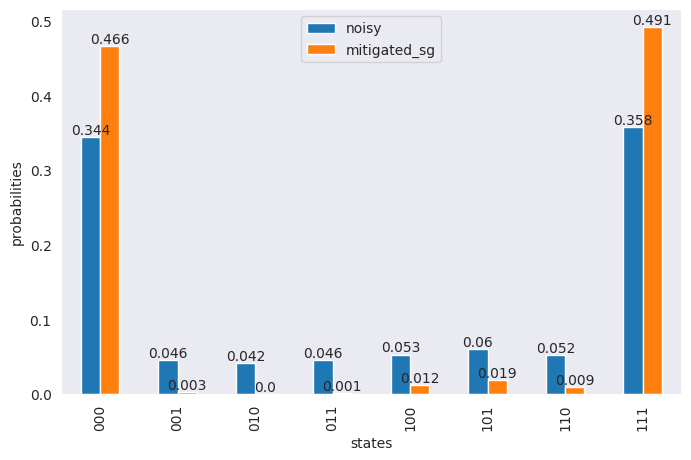

In [15]:
df = pd.DataFrame(
    {
        "states": states,
        "noisy": np.around(noisy_res_1 / sum(noisy_res_1), 3),
        "mitigated_sg": np.around(mitigated / sum(mitigated), 3),
    }
)

ax = df.plot(x="states", y=["noisy", "mitigated_sg"], kind="bar", figsize=(8, 5))
ax.bar_label(ax.containers[0], labels=df["noisy"])
ax.bar_label(ax.containers[1], labels=df["mitigated_sg"])
ax.set_ylabel("probabilities")
plt.show()

## Inverse confusion matrix from k local confusion matrices

This method works under the assumption that the readout errors for different qubits are independent of each other and the confusion matrix $A$ can be factorized into the product of $k$ small local confusion matrices. We consider the special case when $k = n$ for $n$ qubits and different $2 \times 2$ confusion matrices for each qubit

$$
A = A_1 \otimes \dots \otimes A_n
$$

In [16]:
local_labels = [[0] * n_qubits, [1] * n_qubits]
local_states = ["0" * n_qubits, "1" * n_qubits]

results = [
    cudaq.sample(kernel, n_qubits, label, shots_count=shots, noise_model=noise_2)
    for label in local_labels
]

for i, state in enumerate(local_states):
    res = dict(list(results[i].items()))
    print(f"{state} becomes {res}")

000 becomes {'000': 388, '010': 235, '111': 18, '001': 174, '011': 79, '100': 58, '101': 28, '110': 44}
111 becomes {'000': 23, '010': 38, '111': 370, '001': 40, '011': 60, '100': 107, '101': 224, '110': 162}


The local confusion matrices are generated using the marginal probability distribution for each qubit.

In [17]:
counts = [dict(list(results[i].items())) for i, state in enumerate(local_states)]
matrices = []

for k in range(n_qubits):
    matrix = np.zeros([2, 2], dtype=float)
    marginalized_counts = []
    total_shots = []
    for i in range(2):
        marginal_cts = dict(results[i].get_marginal_counts([k]).items())
        marginalized_counts.append(marginal_cts)
        total_shots.append(sum(marginal_cts.values()))

    # matrix[i][j] is the probability of counting i for expected j
    for i in range(2):
        for j in range(2):
            matrix[i][j] = marginalized_counts[j].get(str(i), 0) / total_shots[j]
    matrices.append(matrix)

In [18]:
for m in matrices:
    print(m)
    print()

[[0.85546875 0.15722656]
 [0.14453125 0.84277344]]

[[0.6328125  0.38476562]
 [0.3671875  0.61523438]]

[[0.70800781 0.32226562]
 [0.29199219 0.67773438]]



Mitigated counts:
[559  -1 -58  32 -28  26 -16 510]

Corrected for negative counts:
[521   0   0  35   0  22   0 446]


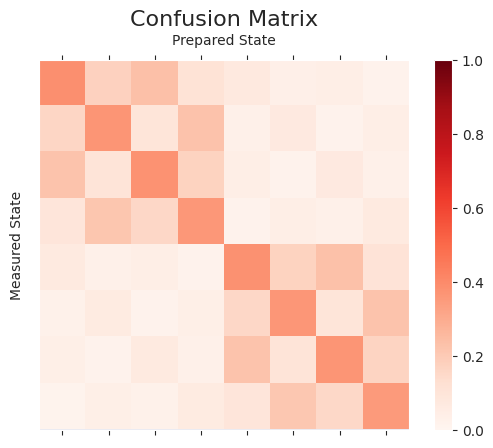

In [19]:
# To find the joint pseudoinverse confusion matrix, we can first perform pseudoinverse of the
# local confusion matrices and then do the tensor product

pinv_confusion_matrices = [np.linalg.pinv(m) for m in matrices]
A_pinv = reduce(np.kron, pinv_confusion_matrices)

mitigated = np.array(np.dot(A_pinv, noisy_res_2), dtype=int)
print(f"Mitigated counts:\n{mitigated}")

if not np.all(mitigated >= 0):
    positive_dist = find_closest_distribution(mitigated / shots)
    mitigated = get_counts_from_distribution(n_qubits, shots, positive_dist)
    print(f"\nCorrected for negative counts:\n{mitigated}")

A_joint = reduce(np.kron, matrices)
plot_cmat(A_joint)

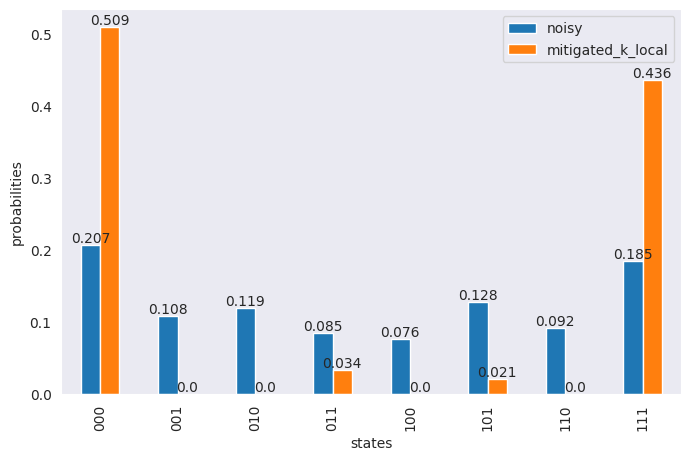

In [20]:
df = pd.DataFrame(
    {
        "states": states,
        "noisy": np.around(noisy_res_2 / sum(noisy_res_2), 3),
        "mitigated_k_local": np.around(mitigated / sum(mitigated), 3),
    }
)

ax = df.plot(x="states", y=["noisy", "mitigated_k_local"], kind="bar", figsize=(8, 5))
ax.bar_label(ax.containers[0], labels=df["noisy"])
ax.bar_label(ax.containers[1], labels=df["mitigated_k_local"])
ax.set_ylabel("probabilities")
plt.show()

## Inverse of full confusion matrix

Here we generate a quantum circuit for each of the basis states of $n$ qubits (i.e., $2^n$ combinations). This gives more accurate readout error mitigation. Since it scales exponentially with the number of qubits, it is only practical for small devices.

In [21]:
results = [
    cudaq.sample(kernel, n_qubits, label, shots_count=shots, noise_model=noise_2)
    for label in labels
]

for i, state in enumerate(states):
    res = dict(list(results[i].items()))
    print(f"{state} becomes {res}")

000 becomes {'000': 367, '010': 248, '111': 17, '001': 159, '011': 83, '100': 68, '101': 35, '110': 47}
001 becomes {'000': 161, '010': 93, '111': 46, '001': 363, '011': 253, '100': 17, '101': 76, '110': 15}
010 becomes {'000': 234, '010': 378, '111': 27, '001': 100, '011': 150, '100': 36, '101': 25, '110': 74}
011 becomes {'000': 106, '010': 145, '111': 65, '001': 251, '011': 386, '100': 11, '101': 30, '110': 30}
100 becomes {'000': 83, '010': 34, '111': 99, '001': 29, '011': 18, '100': 388, '101': 144, '110': 229}
101 becomes {'000': 22, '010': 13, '111': 247, '001': 70, '011': 43, '100': 163, '101': 371, '110': 95}
110 becomes {'000': 32, '010': 77, '111': 157, '001': 14, '011': 30, '100': 233, '101': 85, '110': 396}
111 becomes {'000': 14, '010': 31, '111': 393, '001': 38, '011': 60, '100': 95, '101': 233, '110': 160}


In [22]:
# generate full confusion matrix
A_full = np.zeros((2**n_qubits, 2**n_qubits))
for i, state in enumerate(states):
    true_state = int(state, 2)
    for key, val in results[i].items():
        observed_state = int(key, 2)
        A_full[observed_state][true_state] = val / shots

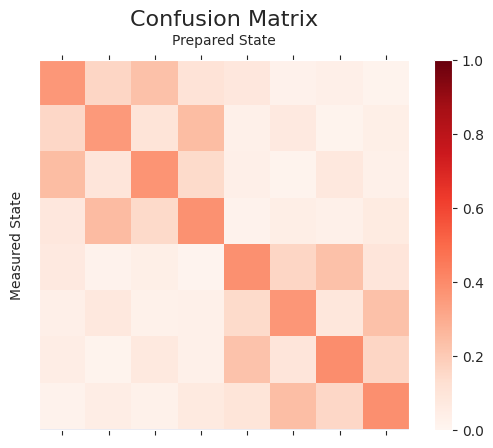

In [23]:
plot_cmat(A_full)

In [24]:
# Distance between full confusion matrix and tensored confusion matrix
np.linalg.norm(A_joint - A_full)

0.09734490298929

In [25]:
A_pinv = np.linalg.pinv(A_full)
mitigated = np.array(np.dot(A_pinv, noisy_res_2), dtype=int)
print(f"Mitigated counts:\n{mitigated}")

if not np.all(mitigated >= 0):
    positive_dist = find_closest_distribution(mitigated / shots)
    mitigated = get_counts_from_distribution(n_qubits, shots, positive_dist)
    print(f"\nCorrected for negative counts:\n{mitigated}")

Mitigated counts:
[ 714 -100 -211  152  -49   63   32  422]

Corrected for negative counts:
[683   0   0  39   0   0   0 302]


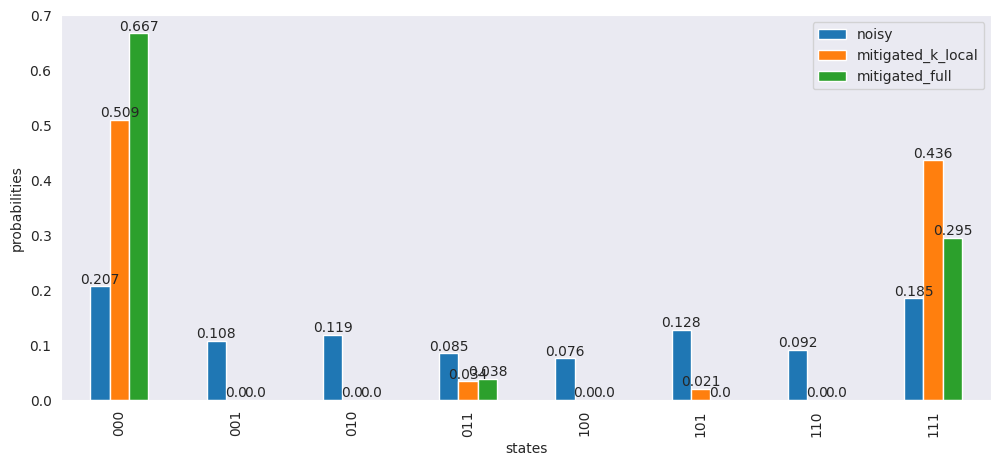

In [26]:
df["mitigated_full"] = np.around(mitigated / sum(mitigated), 3)

ax = df.plot(
    x="states",
    y=["noisy", "mitigated_k_local", "mitigated_full"],
    kind="bar",
    figsize=(12, 5),
)
ax.bar_label(ax.containers[0], labels=df["noisy"])
ax.bar_label(ax.containers[1], labels=df["mitigated_k_local"])
ax.bar_label(ax.containers[2], labels=df["mitigated_full"])
ax.set_ylabel("probabilities")
plt.show()